In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib
import matplotlib.pyplot as plt
import gym
import gym_platoon
import sc

# From DQN tutorial on Keras

In [2]:
# Configuration paramaters for the whole setup
seed = 42
gamma = 0.8  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 20

In [3]:
# Platooning Environment defined in gym-platoon
env = gym.make('platoon-v1')
env.seed(seed)
num_states = env.observation_space.shape[0]
print(env.reset())

[ 0 10  0  0]


/Users/srahmoun/opt/anaconda3/envs/rlsc/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [4]:
num_actions = 9


def create_q_model():
    
    inputs = layers.Input(shape=(num_states,))
    layer1 = layers.Dense(256, activation="relu")(inputs)
    layer2 = layers.Dense(256, activation="relu")(layer1)
    action = layers.Dense(1, activation="linear")(layer2)


    return keras.Model(inputs=inputs, outputs=action)


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()

2021-12-01 06:57:17.991757: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-01 06:57:17.993494: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [5]:
def translateAction(action):
    if action == 0:
        return [1,1]
    if action == 1:
        return [1,0]
    if action == 2: 
        return [1,-1]
    if action == 3:
        return [-1, 1]
    if action == 4:
        return [-1, 0]
    if action == 5:
        return [-1,-1]
    if action == 6:
        return [0,-1]
    if action == 7:
        return [0,1]
    if action == 8:
        return [0,0]

In [6]:
def translateState(state):
    xl = [state[0], state[1]] 
    vl = [state[2], state[3]]
    return xl, vl

In [37]:
# Adam Optimizer w/ Learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()
# Plotting purposes
episodes = []
cumulative_reward = []
cumulative_crashes = []
running_crashes = 0

while (episode_count < 800):  # Run until solved
    state = np.array(env.reset())
    xl, vl = translateState(state)
    cont = sc.Controller(xl, vl)
    episode_reward = 0
    episode_crash = 0
    

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = state_next

        if (not cont.isSafe(translateAction(action))):
            reward = -400 
        
        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = np.array(state_next)
        
        if state[0] > state[1]: 
            episode_crash += 1 

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1
    cumulative_reward += [running_reward]
    cumulative_crashes += [episode_crash]
    episodes += [episode_count]

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

running reward: -138.59 at episode 666, frame count 10000


In [38]:
print(running_reward)

-169.06


In [35]:
print(running_crashes)

463


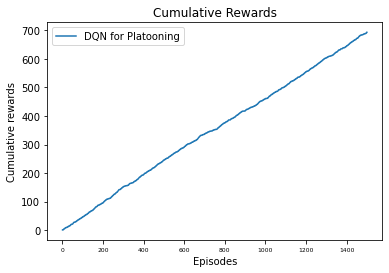

In [32]:
plt.title('Cumulative Rewards')
plt.plot(episodes, cumulative_crashes, label='DQN for Platooning')
plt.xticks(fontsize=6)
plt.xlabel('Episodes')
plt.ylabel('Cumulative rewards')
plt.legend()
plt.show()

In [25]:
print(state)

[ 15 102   1   7]


*Interesting Note:* Even though it's punished if vehicle 2 gets in front of vehicle 1, the RL still chooses to go in the negative index. 10 - x2 + x1. 